/home/yisi/Programs/anaconda2/lib/python2.7/site-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


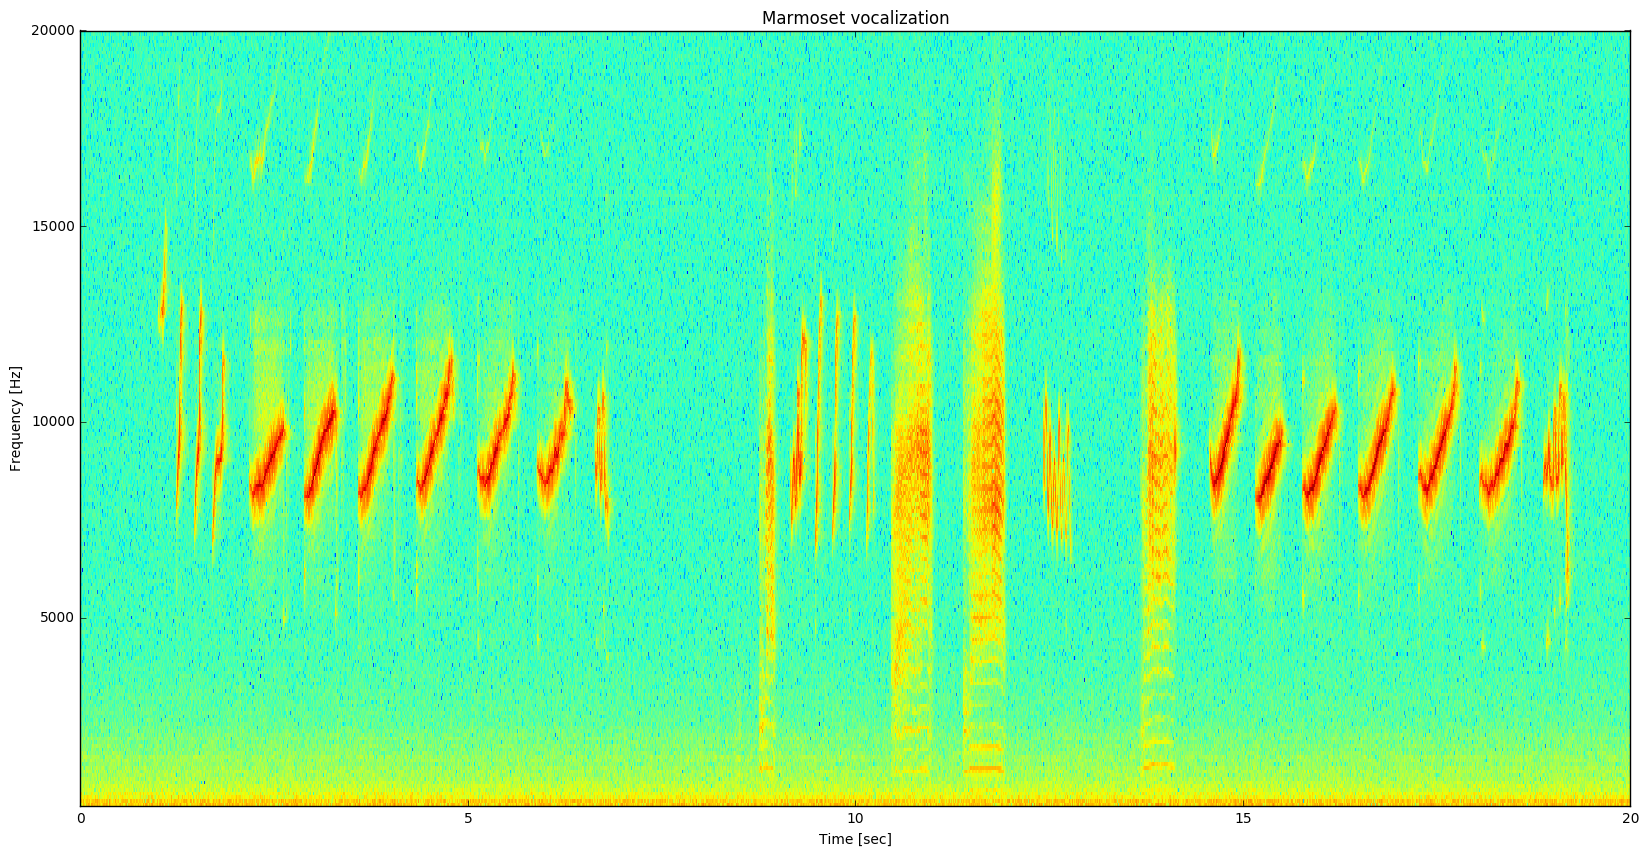

In [1]:
# read sound file
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fs, data = wavfile.read('/media/yisi/Data/Larynx/LarynxBehavior/BehaviorAnalysis_infant/Barbtwin1/mic1_baseline_foam_barbtwin1_022612.wav')
data = data[int(fs * 172): int(fs * 192), 1]
f, t, Sxx = signal.spectrogram(data, fs, nperseg = 1024, noverlap = 800, nfft = 1024, scaling='spectrum')

cmap = cm.get_cmap('jet')
plt.figure(figsize=(20,10))
plt.pcolormesh(t, f, np.log(Sxx), cmap = cmap)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim((200, 20000))
plt.title('Marmoset vocalization')
plt.show()

Calls can be classified into 5 major types with distinct acoustic features.
![caption](acousticfeatureexample.png)

In [2]:
import scipy.io as sio
import os 
import seaborn as sns
import pandas as pd
from pandas.tools.plotting import scatter_matrix

## Data

In [3]:
# read data
mat_data = sio.loadmat('infantvocaldata.mat')
# separate data to training and test sets
X, y = mat_data["features"], mat_data["labels"][0,:]

df = pd.DataFrame({
    'duration': mat_data["features"][:,0],
    'entropy': mat_data["features"][:,1],
    'entropyVar': mat_data["features"][:,2],
    'amplitude': mat_data["features"][:,3],
    'dominantFrequency': mat_data["features"][:,4],
    'f0Slope': mat_data["features"][:,5],
    'f0Var': mat_data["features"][:,6],
    'f0': mat_data["features"][:,7],
})

print('# Phee: %d' % np.sum(y==1))
print('# Twitter: %d' % np.sum(y==2))
print('# Trill: %d' % np.sum(y==3))
print('# Cry: %d' % np.sum(y==4))
print('# PheeCry: %d' % np.sum(y==5))

# Phee: 4983
# Twitter: 5503
# Trill: 1021
# Cry: 3288
# PheeCry: 950


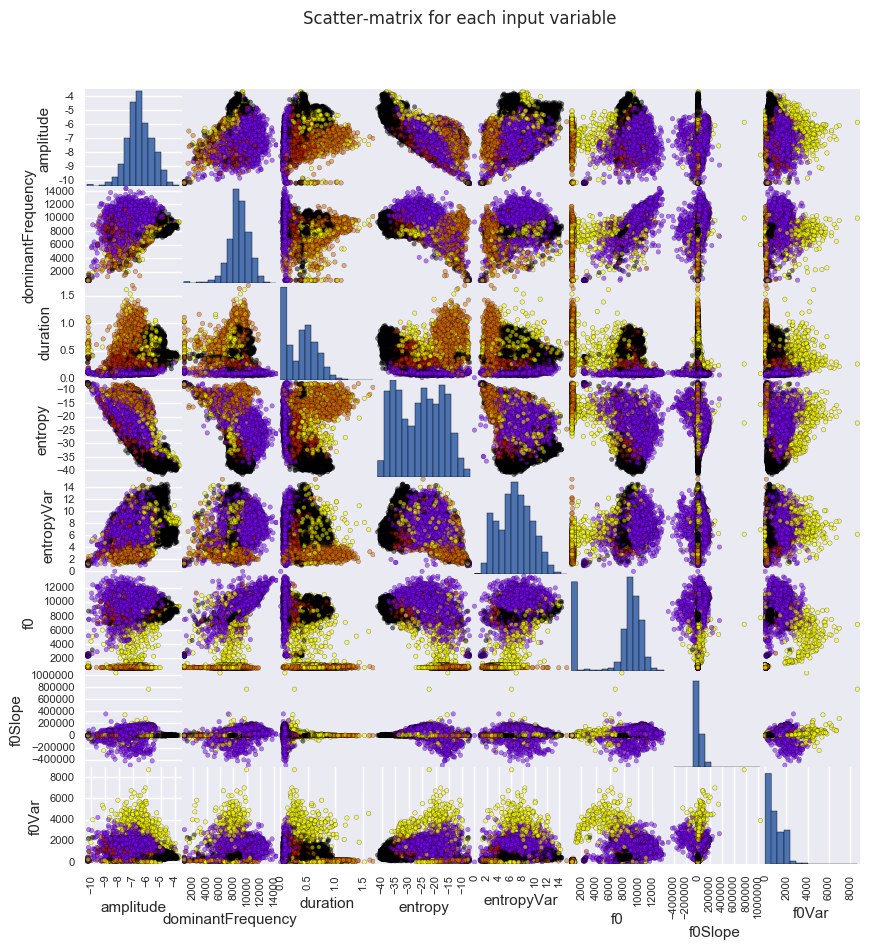

In [4]:
cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(df, c = y, marker = 'o', s=10, hist_kwds={'bins':15}, figsize=(10,10), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')
plt.savefig('scatterMatrix')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(11808, 8)
(3937, 8)


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

print('Components:')
print(pca.components_)
print('Explained variances:')
print(pca.explained_variance_)

Components:
[[ 0.19916719  0.49905959 -0.35007409 -0.15183192 -0.17133832 -0.02363837
  -0.11520319 -0.72282763]
 [-0.51186708  0.63310236  0.14386638 -0.43928281  0.0696541   0.05716492
   0.21028369  0.26677297]
 [ 0.07779502  0.13822808  0.87097926  0.14657241 -0.35994917 -0.05168119
  -0.08481516 -0.2352119 ]
 [ 0.01120155 -0.28596459 -0.13204854 -0.55569163 -0.72467349 -0.09852197
  -0.15055654  0.18531934]
 [ 0.80301752  0.1886764   0.15207107 -0.37618445  0.26411826 -0.01836289
   0.05031328  0.28687394]]
Explained variances:
[0.14940538 0.05532984 0.0152793  0.00940094 0.00752401]


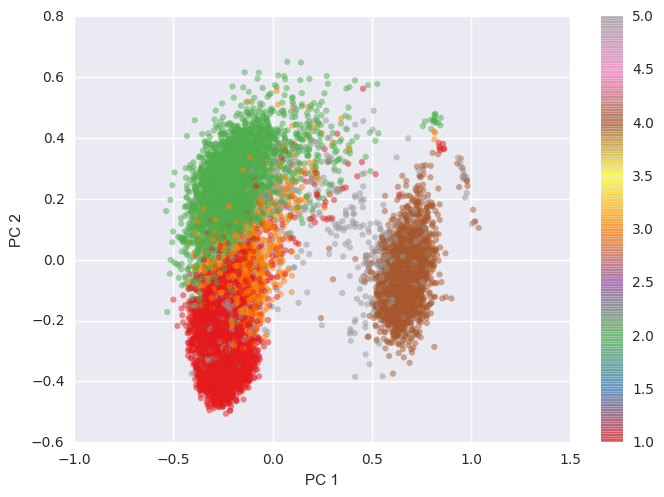

In [7]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
           cmap=plt.cm.get_cmap('Set1'))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar();
plt.show()

## Classification

### Linear Models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

cv_scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test, y_test)))

Cross validation accuracy: 0.8836 (+\- 0.0097)
Accuracy of Logistic regression classifier on training set: 0.8841
Accuracy of Logistic regression classifier on test set: 0.8880


In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

cv_scores = cross_val_score(lda, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of LDA classifier on training set: {:.4f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.4f}'
     .format(lda.score(X_test, y_test)))

Cross validation accuracy: 0.8921 (+\- 0.0147)
Accuracy of LDA classifier on training set: 0.8923
Accuracy of LDA classifier on test set: 0.8890


In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

cv_scores = cross_val_score(qda, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of LDA classifier on training set: {:.4f}'
     .format(qda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.4f}'
     .format(qda.score(X_test, y_test)))

Cross validation accuracy: 0.9127 (+\- 0.0103)
Accuracy of LDA classifier on training set: 0.9145
Accuracy of LDA classifier on test set: 0.9121


### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)

cv_scores = cross_val_score(dt, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of Decision Tree classifier on training set: {:.4f}'
     .format(dt.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.4f}'
     .format(dt.score(X_test, y_test)))

Cross validation accuracy: 0.9336 (+\- 0.0113)
Accuracy of Decision Tree classifier on training set: 1.0000
Accuracy of Decision Tree classifier on test set: 0.9332


### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

cv_scores = cross_val_score(rf, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of Random Forest classifier on training set: {:.4f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.4f}'
     .format(rf.score(X_test, y_test)))

/home/yisi/Programs/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Cross validation accuracy: 0.9575 (+\- 0.0103)
Accuracy of Random Forest classifier on training set: 0.9999
Accuracy of Random Forest classifier on test set: 0.9571


### K-Nearest-Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

cv_scores = cross_val_score(knn, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test, y_test)))

Cross validation accuracy: 0.9305 (+\- 0.0067)
Accuracy of K-NN classifier on training set: 0.9457
Accuracy of K-NN classifier on test set: 0.9335


### Gaussian Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

cv_scores = cross_val_score(gnb, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of GNB classifier on training set: {:.4f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.4f}'
     .format(gnb.score(X_test, y_test)))

Cross validation accuracy: 0.8922 (+\- 0.0120)
Accuracy of GNB classifier on training set: 0.8919
Accuracy of GNB classifier on test set: 0.8867


### Support Vector Machine

In [15]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

cv_scores = cross_val_score(svm, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of SVM classifier on training set: {:.4f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.4f}'
     .format(svm.score(X_test, y_test)))

Cross validation accuracy: 0.8974 (+\- 0.0118)
Accuracy of SVM classifier on training set: 0.8991
Accuracy of SVM classifier on test set: 0.8971


In [16]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge"))
    ])

polynomial_svm.fit(X_train, y_train)

cv_scores = cross_val_score(polynomial_svm, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of SVM classifier on training set: {:.4f}'
     .format(polynomial_svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.4f}'
     .format(polynomial_svm.score(X_test, y_test)))

Cross validation accuracy: 0.9535 (+\- 0.0089)
Accuracy of SVM classifier on training set: 0.9610
Accuracy of SVM classifier on test set: 0.9540


### Neural Network

In [17]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(alpha = 0.01)
nn.fit(X_train, y_train)

cv_scores = cross_val_score(nn, X_train, y_train, cv=10)
print('Cross validation accuracy: %0.4f (+\- %0.4f)' % (cv_scores.mean(), cv_scores.std() * 2))
print('Accuracy of Neural Network classifier on training set: {:.4f}'
     .format(nn.score(X_train, y_train)))
print('Accuracy of Neural Network classifier on test set: {:.4f}'
     .format(nn.score(X_test, y_test)))

Cross validation accuracy: 0.9192 (+\- 0.0081)
Accuracy of Neural Network classifier on training set: 0.92
Accuracy of Neural Network classifier on test set: 0.92


## Insights

### Confusion Matrices

Random Forest:
[[1203   10   32    0    5]
 [   9 1365    6    0    1]
 [  45   30  183    0    3]
 [   0    0    0  817    0]
 [  15    5    3    5  200]]
             precision    recall  f1-score   support

          1       0.95      0.96      0.95      1250
          2       0.97      0.99      0.98      1381
          3       0.82      0.70      0.75       261
          4       0.99      1.00      1.00       817
          5       0.96      0.88      0.92       228

avg / total       0.96      0.96      0.96      3937



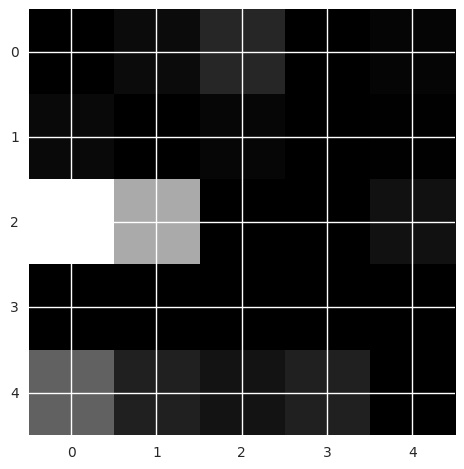

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = rf.predict(X_test)
conf_mx = confusion_matrix(y_test, pred)
norm_conf_mx = conf_mx.astype(np.float64) / conf_mx.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mx, 0.0)
print('Random Forest:')
print(conf_mx)
print(classification_report(y_test, pred))
plt.imshow(norm_conf_mx, interpolation='nearest', cmap=plt.cm.gray)
plt.show()

K-Nearest-Neighbors:
[[1195   18   36    0    1]
 [  10 1361    7    1    2]
 [  62   32  167    0    0]
 [   0    0    0  810    7]
 [  16    8    3   59  142]]
             precision    recall  f1-score   support

          1       0.93      0.96      0.94      1250
          2       0.96      0.99      0.97      1381
          3       0.78      0.64      0.70       261
          4       0.93      0.99      0.96       817
          5       0.93      0.62      0.75       228

avg / total       0.93      0.93      0.93      3937



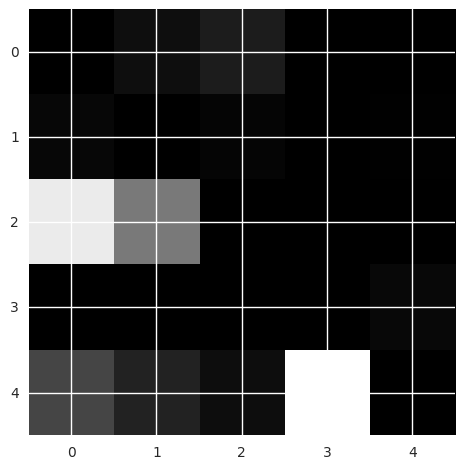

In [19]:
pred = knn.predict(X_test)
conf_mx = confusion_matrix(y_test, pred)
norm_conf_mx = conf_mx.astype(np.float64) / conf_mx.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mx, 0.0)
print('K-Nearest-Neighbors:')
print(conf_mx)
print(classification_report(y_test, pred))
plt.imshow(norm_conf_mx, interpolation='nearest', cmap=plt.cm.gray)
plt.show()

### Feature Importance

/home/yisi/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


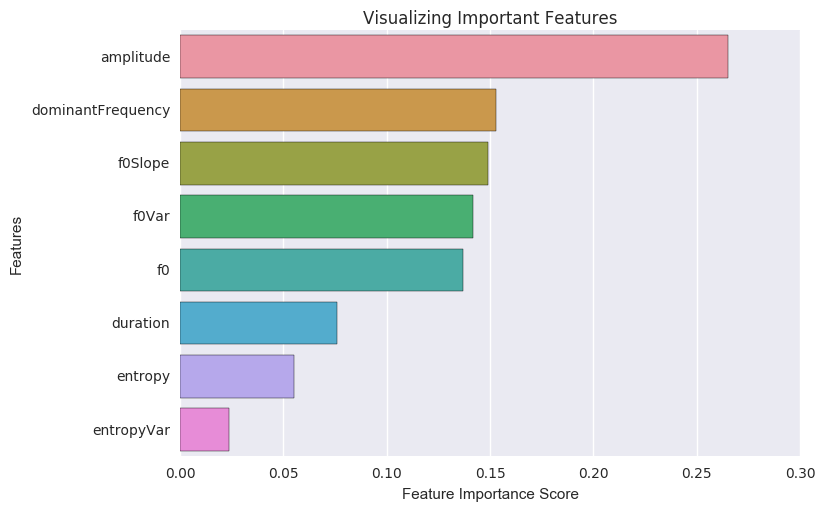

In [20]:
import pandas as pd
feature_imp = pd.Series(rf.feature_importances_,index=df.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [22]:
print('KNN Feature Accuracy:')
for i in range(X.shape[1]):
    X_i = X_train[:, i].reshape(-1, 1)
    cv_scores = cross_val_score(knn, X_i, y_train)
    print('%s : %g' % (df.columns[i], cv_scores.mean()))

KNN Feature Accuracy:
amplitude : 0.68987
dominantFrequency : 0.746018
duration : 0.564193
entropy : 0.509739
entropyVar : 0.528795
f0 : 0.853742
f0Slope : 0.800221
f0Var : 0.741363


/home/yisi/Programs/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/yisi/Programs/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/yisi/Programs/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:552: ChangedBehaviorWarning: The decision_function_shape default value will change from 'ovo' to 'ovr' in 0.19. This will change the shape of the decision function returned by SVC.
  "SVC.", ChangedBehaviorWarning)


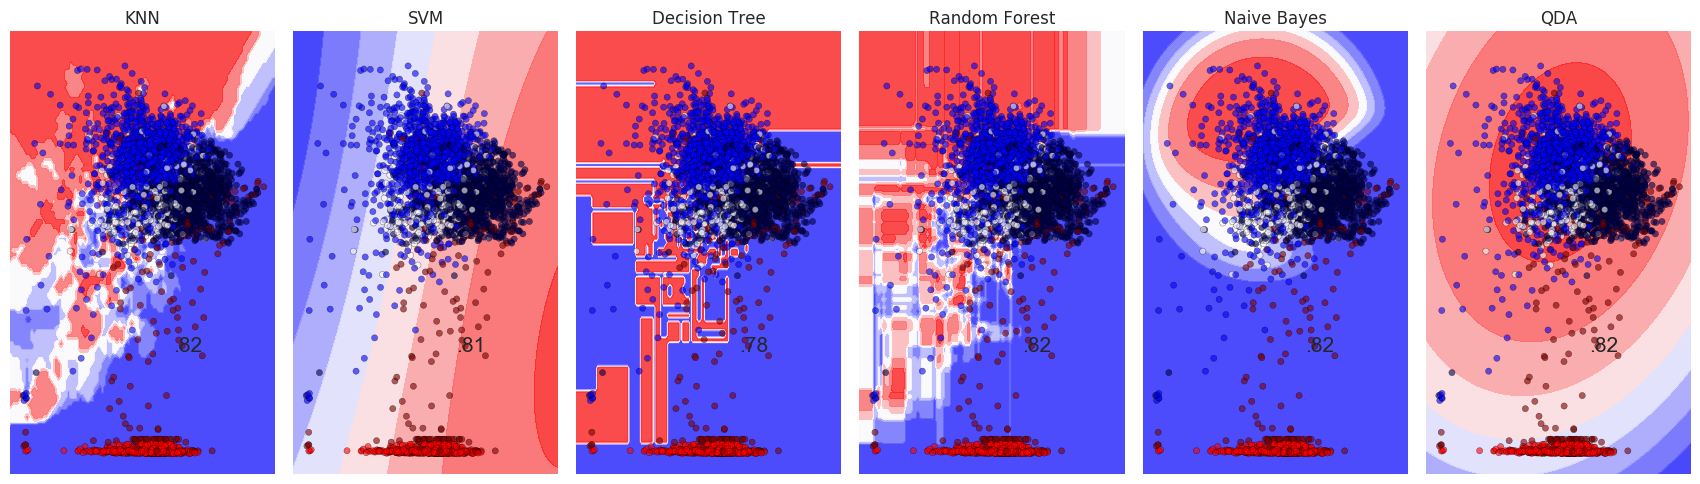

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification


h = .01  # step size in the mesh

names = ["KNN", "SVM","Decision Tree", "Random Forest",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


figure = plt.figure(figsize=(20, 5))
cm = plt.cm.bwr
cm_bright = plt.cm.seismic

x_min, x_max = X_train[:, 3].min() - .05, X_train[:, 3].max() + .05
y_min, y_max = X_train[:, 7].min() - .05, X_train[:, 7].max() + .05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

# iterate over classifiers
i = 1
for name, clf in zip(names, classifiers):
        
    ax = plt.subplot(1, len(classifiers) + 1, i)

    clf.fit(X_train[:,[3,7]], y_train)
    score = clf.score(X_test[:, [3,7]], y_test)

    # Plot the decision boundary. 
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # plot testing points
    ax.scatter(X_test[:, 3], X_test[:, 7], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
    i += 1
    
plt.tight_layout()
plt.show()

## Generalization

In [24]:
import itertools
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def subject_generalization(X, y, subject, npred, clf):
    nsub = np.unique(subject)
    combs = itertools.combinations(nsub, npred)
    sclst = []
    for i in list(combs):
        X_train_i = X[np.in1d(subject, i),:]
        y_train_i = y[np.in1d(subject, i)]
        X_test_i = X[~np.in1d(subject, i),:]
        y_test_i = y[~np.in1d(subject, i)]
        scaler = MinMaxScaler()
        X_train_i = scaler.fit_transform(X_train_i)
        X_test_i = scaler.transform(X_test_i)    

        clf.fit(X_train_i, y_train_i)
        score = clf.score(X_test_i, y_test_i)
        sclst.append(score)
        
    return np.mean(sclst), np.std(sclst)


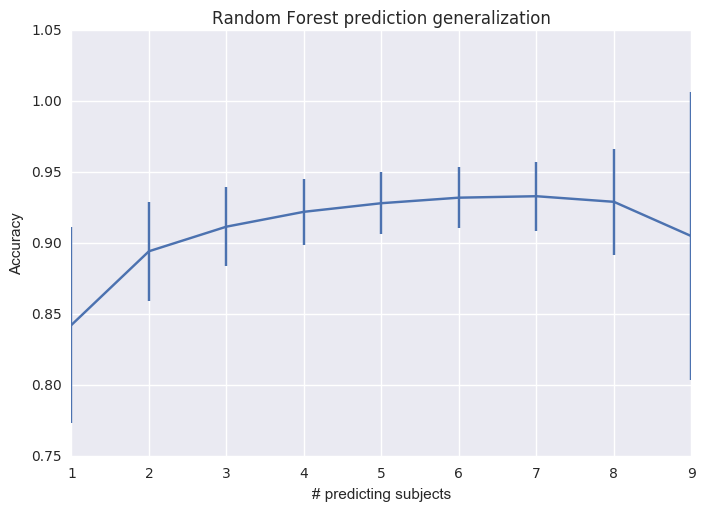

In [25]:
subject = mat_data["subject"][0,:]
clf = RandomForestClassifier(n_estimators=100)
score_rf = np.empty((0))
score_rf_err = np.empty((0))
for i in range(1,10):
    m, s = subject_generalization(X, y, subject, i, clf)
    score_rf = np.append(score_rf, m)
    score_rf_err = np.append(score_rf_err, s)
plt.errorbar(np.arange(1,10), score_rf, score_rf_err)
plt.xlabel('# predicting subjects')
plt.ylabel('Accuracy')
plt.title("Random Forest prediction generalization")
plt.show()

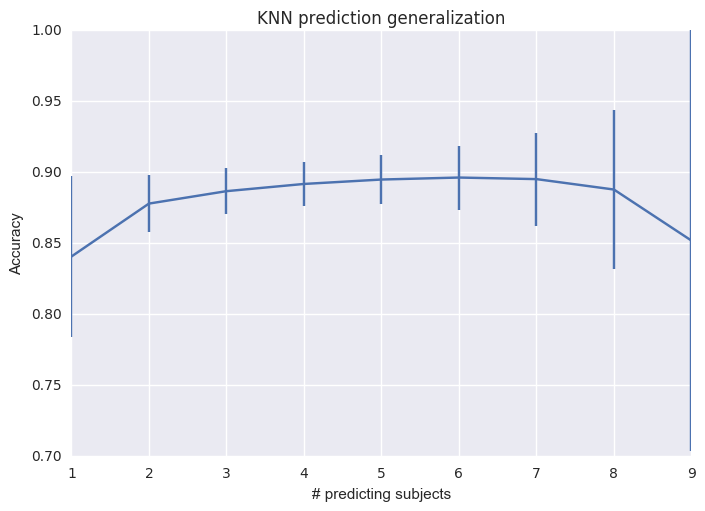

In [26]:
subject = mat_data["subject"][0,:]
clf = KNeighborsClassifier()
score_knn = np.empty((0))
score_knn_err = np.empty((0))
for i in range(1,10):
    m, s = subject_generalization(X, y, subject, i, clf)
    score_knn = np.append(score_knn, m)
    score_knn_err = np.append(score_knn_err, s)
plt.errorbar(np.arange(1,10), score_knn, score_knn_err)
plt.xlabel('# predicting subjects')
plt.ylabel('Accuracy')
plt.title("KNN prediction generalization")
plt.show()